In [1]:
import torch
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

batch_size = 100
trainset = MNIST('.', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

In [2]:
in_features = 1 * 28 * 28

class Discriminator(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, 384, bias=False)
        self.fc2 = torch.nn.Linear(384, 128, bias=False)
        self.fc3 = torch.nn.Linear(128, 1, bias=False)
        self.relu = torch.nn.LeakyReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 0 to 1(0: fake, 1: true)
        return x

In [3]:
netD = Discriminator(in_features)

iterator = iter(trainloader)
img, _ = next(iterator)

D_out = netD(img.reshape(batch_size, -1))

print(D_out[0:5])

tensor([[0.4867],
        [0.4795],
        [0.4822],
        [0.5044],
        [0.4985]], grad_fn=<SliceBackward>)


In [4]:
zsize = 100

class Generator(torch.nn.Module):
    def __init__(self, zsize, in_features):
        super().__init__()
        self.fc1 = torch.nn.Linear(zsize, 256, bias=False)
        self.fc2 = torch.nn.Linear(256, 512, bias=False)
        self.fc3 = torch.nn.Linear(512, in_features, bias=False)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # -1 to 1
        return x

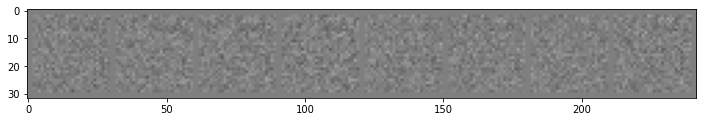

In [5]:
netG = Generator(zsize, in_features)

z = torch.randn(batch_size, zsize)

output = netG(z)

imshow(output[0:8].reshape(-1, 1, 28, 28))

In [6]:
G_out = netD(output)

print(G_out[0:5])

tensor([[0.4989],
        [0.4996],
        [0.5005],
        [0.4997],
        [0.5004]], grad_fn=<SliceBackward>)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'using: {device}')

netD = Discriminator(in_features).to(device)
netG = Generator(zsize, in_features).to(device)

using: cuda


In [8]:
criterion = torch.nn.BCELoss().to(device)

one_labels = torch.ones(batch_size).to(device)
zero_labels = torch.zeros(batch_size).to(device)

optimizer_netD = optim.Adam(netD.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_netG = optim.Adam(netG.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [ ]:
losses_netD = []
losses_netG = []
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    running_loss_netD = 0.0
    running_loss_netG = 0.0
    for count, (real_imgs, _) in enumerate(trainloader, 1):
        netD.zero_grad()

        # 識別器の学習
        real_imgs = real_imgs.to(device)

        # データローダーからデータを読み込み、識別器に入力し、損失を計算
        output_real_imgs = netD(real_imgs.reshape(batch_size, -1))
        output_real_imgs = output_real_imgs.reshape(batch_size)
        loss_real_imgs = criterion(output_real_imgs, one_labels)
        loss_real_imgs.backward()

        # 生成器から得たデータを、識別器に入力し、損失を計算
        z = torch.randn(batch_size, zsize).to(device)
        fake_imgs = netG(z)
        output_fake_imgs = netD(fake_imgs.detach()).reshape(batch_size)
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)
        loss_fake_imgs.backward()

        # それらをまとめたものが最終的な損失
        loss_netD = loss_real_imgs + loss_fake_imgs
        optimizer_netD.step()
        running_loss_netD += loss_netD

        # 生成器の学習
        netG.zero_grad()
        z = torch.randn(batch_size, zsize).to(device)
        fake_imgs = netG(z)
        output_fake_imgs = netD(fake_imgs).reshape(batch_size)
        loss_netG = criterion(output_fake_imgs, one_labels)
        loss_netG.backward()
        optimizer_netG.step()
        running_loss_netG += loss_netG

    running_loss_netD /= count
    running_loss_netG /= count
    print(f'epoch: {epoch}, netD loss: {running_loss_netD}, netG loss: {running_loss_netG}')
    losses_netD.append(running_loss_netD.cpu())
    losses_netG.append(running_loss_netG.cpu())
    if epoch % 10 == 0:
        z = torch.randn(batch_size, zsize).to(device)
        generated_imgs = netG(z).cpu()
        imshow(generated_imgs[0:8].reshape(8, 1, 28, 28))

epoch: 1, netD loss: 1.0834331512451172, netG loss: 0.7720438838005066


In [9]:
import tenseal as ts

In [10]:
class EncDiscriminator:
    def __init__(self, torch_nn):
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc3_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc3_bias = torch_nn.fc1.bias.data.tolist()
        
        
    def forward(self, enc_x, windows_nb):
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weights) + self.fc1_bias
        # square activation
        enc_x.square_()
        
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weights) + self.fc2_bias
        # square activation
        enc_x.square_()
        
        # fc3 layer
        enc_x = enc_x.mm(self.fc3_weights) + self.fc3_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [11]:
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data, target in test_loader:
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

In [12]:
batch_size = 100
testset = MNIST('.', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)


# Load one element at a time
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
# required for encoding
#kernel_shape = netD.fc1.kernel_size
kernel_shape = 7
#stride = netD.fc1.stride[0]
stride = 3

In [13]:
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
enc_model = EncDiscriminator(netD)
enc_test(context, enc_model, testloader, criterion, kernel_shape, stride)

In [16]:
losses_netD = []
losses_netG = []
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    running_loss_netD = 0.0
    running_loss_netG = 0.0
    #for count, (real_imgs, _) in enumerate(trainloader, 1):
    for count, data in enumerate(trainloader, 1):
        netD.zero_grad()

        # 識別器の学習
        real_imgs = real_imgs.to(device)
        
        #real_imgs, _ = data
        
        vec = real_imgs.flatten()
        #encrypted_vec = ts.ckks_vector(context, vec)
        encrypted_vec = ts.ckks_tensor(context, vec)

        # データローダーからデータを読み込み、識別器に入力し、損失を計算
        output_real_imgs = netD(real_imgs.reshape(batch_size, -1))
        output_real_imgs = output_real_imgs.reshape(batch_size)
        loss_real_imgs = criterion(output_real_imgs, one_labels)
        loss_real_imgs.backward()

        # 生成器から得たデータを、識別器に入力し、損失を計算
        z = torch.randn(batch_size, zsize).to(device)
        fake_imgs = netG(z)
        output_fake_imgs = netD(fake_imgs.detach()).reshape(batch_size)
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)
        loss_fake_imgs.backward()

        # それらをまとめたものが最終的な損失
        loss_netD = loss_real_imgs + loss_fake_imgs
        optimizer_netD.step()
        running_loss_netD += loss_netD

        # 生成器の学習
        netG.zero_grad()
        z = torch.randn(batch_size, zsize).to(device)
        fake_imgs = netG(z)
        output_fake_imgs = netD(fake_imgs).reshape(batch_size)
        loss_netG = criterion(output_fake_imgs, one_labels)
        loss_netG.backward()
        optimizer_netG.step()
        running_loss_netG += loss_netG

    running_loss_netD /= count
    running_loss_netG /= count
    print(f'epoch: {epoch}, netD loss: {running_loss_netD}, netG loss: {running_loss_netG}')
    #losses_netD.append(running_loss_netD.cpu())
    losses_netD.append(running_loss_netD)
    #losses_netG.append(running_loss_netG.cpu())
    losses_netG.append(running_loss_netG)
    if epoch % 10 == 0:
        z = torch.randn(batch_size, zsize).to(device)
        generated_imgs = netG(z).cpu()
        imshow(generated_imgs[0:8].reshape(8, 1, 28, 28))

TypeError: input isn't a well structured tensor